# Peer-graded Assignment: Capstone Project - The Battle of Neighborhoods (Week 2)

Rahul Nayak

## Market research: Expanding a Restaurant chain into the market in Bengaluru city, India.

### Background:

Vasudev Krishna a hotelier runs a chain of Indian restaurants under the brand name of Vaikunta Experience in the city of Mumbai, India. Building on the success of his venture he wants to expand his business into a new city of Bengaluru, India. While doing his research Vasudev finds out that his friend Gandivdhari Arjuna, an aspiring data scientist has recently completed the IBM DATA SCIENCE professional certificate. Vasudev has requested Arjuna to help him with his problem.

### Business Problem:

Vasudev wants to expand his restaurant chain into the markets of Bengaluru, India. But first, he must do some research. His main dilemma is to decide as to where will he locate his restaurants in Bengaluru. He wants to expand into areas that have the least Indian restaurants in their vicinity, neighborhoods that are not known for their restaurants. He is confident that his food will find takers as his food is literally the food of the gods. Hence he enlists the help of his dear friend Arjuna, who with his recent experience with machine learning techniques and the foursquare API has promised Vasudev that he will solve his dilemma. Arjuna has promised Vasudev that he will look up details on all the neighborhoods in Bengaluru and find out which of them have popular Indian restaurants within them and will suggest locations in bengaluru where Vasudev can establish his restaurants.

### Data

Firstmost, a list of neighborhoods in Bengaluru will be needed. This list will be obtained from [here](https://www.mapsofindia.com/pincode/india/karnataka/bangalore/), a table containing neighborhood names with respect to its postal code. This table will have to be read into a dataframe.

Next we will need the latitude and longitude for each neighborhood. for this we will use the google maps search nearby function.(data complied into a csv file available [here](http://s000.tinyupload.com/?file_id=04845440732025580094).)

Next we will use the Foursquare API to make calls (The tutorial can be found [here](https://www.coursera.org/learn/applied-data-science-capstone/home/week/2)) to get the top 10 venues in each neighborhood.  

Next we will use classification technique of K-Means clustering to group the neighborhood into clusters (based on the result of the elbow test) and we will study the top 10 venues in each cluster.

We will suggest Vasudev to open his restaurants in the clusters that don't have Indian restaurants as their top venues.


_________________________________________________________________

## Part 1

### Importing data

We will now import the Bengaluru Neighbourhood list.

In [11]:
import requests
import pandas as pd

url = 'https://www.mapsofindia.com/pincode/india/karnataka/bangalore/'
html = requests.get(url).content
df_list = pd.read_html(html)
df = df_list[0]
print(df.head)

<bound method NDFrame.head of               Pincode Details Pincode Details.1 Pincode Details.2  \
0                    Location           Pincode             State   
1       A F station yelahanka            560063         Karnataka   
2                     Adugodi            560030         Karnataka   
3                       Agara            560034         Karnataka   
4                       Agram            560007         Karnataka   
..                        ...               ...               ...   
290                 Yelahanka            560064         Karnataka   
291  Yelahanka Satellite town            560064         Karnataka   
292                   Yemalur            560037         Karnataka   
293        Yeshwanthpur Bazar            560022         Karnataka   
294              Yeswanthpura            560022         Karnataka   

    Pincode Details.3  
0            District  
1           Bangalore  
2           Bangalore  
3           Bangalore  
4           Bangalore

In [12]:
column_names = ['Neighborhood', 'Pin_Code'] 
nhood_data = pd.DataFrame(columns=column_names)
nhood_data=df.iloc[1:294,0:2]
nhood_data.columns=['Neighborhood', 'Pin_Code']

In [13]:
nhood_data.head()

,Neighborhood,Pin_Code
1,A F station yelahanka,560063
2,Adugodi,560030
3,Agara,560034
4,Agram,560007
5,Air Force hospital,560007


Now we will aggregate and merge neighborhoods with common Pin_code.

In [14]:
nhood_data=nhood_data.groupby("Pin_Code",as_index=False).agg({'Neighborhood': ','.join})

In [15]:
nhood_data.head()

,Pin_Code,Neighborhood
0,560001,"Bangalore Bazaar,Bangalore.,Brigade Road,Cubba..."
1,560002,"Avenue Road,Bangalore City,Bangalore Corporati..."
2,560003,"Aranya Bhavan,Malleswaram,Palace Guttahalli,Sw..."
3,560004,"Basavanagudi,Lalbagh West,Mavalli,Pasmpamahaka..."
4,560005,"Fraser Town,Jeevanahalli"


In [16]:
nhood_data.shape

(99, 2)

Now we need latitude and longitude values.

We will use google maps search nearby to get the data. I have compiled it into a [csv file](http://s000.tinyupload.com/download.php?file_id=04845440732025580094&t=0484544073202558009409231). 

In [58]:
import requests
url='http://s000.tinyupload.com/download.php?file_id=04845440732025580094&t=0484544073202558009409231'
r=requests.get(url,allow_redirects=True)
open('loc_data.csv','wb').write(r.content)

7303

In [17]:
loc_data=pd.read_csv('loc_data.csv')

In [18]:
loc_data.head()

,Pin_Code,Neighborhood,Latitude,Longitude,Pin_Code.1
0,560001,"Bangalore Bazaar,Bangalore.,Brigade Road,Cubba...",12.977776,77.599500,560001
1,560002,"Avenue Road,Bangalore City,Bangalore Corporati...",12.963811,77.582112,560002
2,560003,"Aranya Bhavan,Malleswaram,Palace Guttahalli,Sw...",13.002018,77.571651,560003
3,560004,"Basavanagudi,Lalbagh West,Mavalli,Pasmpamahaka...",12.943886,77.573945,560004
4,560005,"Fraser Town,Jeevanahalli",12.998097,77.622781,560005


We will merge this with original data.

In [19]:
nhood_data=loc_data

_______________________________


## Part 2

## We will Explore and cluster the neighborhoods in Bengaluru.

Let's get the geographical coordinates of Bengaluru.

First we will import required libraries.

<b>you will need to run the following code if you have not worked with Geopy geocoder before:<b> 



In [ ]:
#!conda install -c conda-forge geopy --yes

In [20]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files


from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


Use geopy library to get the latitude and longitude values of Bengaluru City.

In [21]:
address = 'Bangalore'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bangalore are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bangalore are 12.9791198, 77.5912997.


Let us visualise Bengaluru with its neighbourhoods.

In [22]:
# create map of Bengaluru using latitude and longitude values
map_bluru = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(nhood_data['Latitude'], nhood_data['Longitude'], nhood_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bluru)  
    
map_bluru

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

Define Foursquare Credentials and Version


In [88]:
# @hidden_cell
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '202080522' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


We will explore first neighborhood..

In [24]:
nhood_data.loc[0, 'Neighborhood']

'Bangalore Bazaar,Bangalore.,Brigade Road,Cubban Road,Dr. ambedkar veedhi,Highcourt,Legislators Home,Mahatma Gandhi road,Narayan Pillai street,Rajbhavan,Vidhana Soudha'


Get the neighborhood's latitude and longitude values.


In [25]:
neighborhood_latitude = nhood_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = nhood_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = nhood_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Bangalore Bazaar,Bangalore.,Brigade Road,Cubban Road,Dr. ambedkar veedhi,Highcourt,Legislators Home,Mahatma Gandhi road,Narayan Pillai street,Rajbhavan,Vidhana Soudha are 12.977775999999999, 77.5995.


Now, let's get the top 100 venues that are in Brigade Road within a radius of 500 meters.

First, let's create the GET request URL.

In [26]:
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)


Send the GET request and examine the resutls


In [27]:
results = requests.get(url).json()

In [28]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a pandas dataframe.


In [29]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

C:\Users\rahul\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,M. Chinnaswamy Stadium,Cricket Ground,12.978144,77.599223
1,Hard Rock Cafe Bengaluru,American Restaurant,12.976389,77.601468
2,"Shiro, UB City",Lounge,12.976748,77.599066
3,Cubbon Park,Park,12.977042,77.595277
4,Church Street Social,Pub,12.975559,77.602579


Let's create a function to repeat the same process to all the neighborhoods in Bangalore.

In [30]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now we will write the code to run the above function on each neighborhood and create a new dataframe called blore_venues.

In [32]:
blore_venues = getNearbyVenues(names=nhood_data['Neighborhood'],
                                   latitudes=nhood_data['Latitude'],
                                   longitudes=nhood_data['Longitude']
                                  )

Bangalore Bazaar,Bangalore.,Brigade Road,Cubban Road,Dr. ambedkar veedhi,Highcourt,Legislators Home,Mahatma Gandhi road,Narayan Pillai street,Rajbhavan,Vidhana Soudha
Avenue Road,Bangalore City,Bangalore Corporation building,Bangalore Fort,Basavaraja Market,Cahmrajendrapet,Narasimjharaja Road,New Tharaggupet,Sri Jayachamarajendra road
Aranya Bhavan,Malleswaram,Palace Guttahalli,Swimming Pool extn,Venkatarangapura,Vyalikaval Extn
Basavanagudi,Lalbagh West,Mavalli,Pasmpamahakavi Road,Shankarpura,Visveswarapuram
Fraser Town,Jeevanahalli
J.C.nagar,Training Command iaf
Agram,Air Force hospital
H.A.l ii stage,Hulsur Bazaar,Someswarapura
Bangalore Dist offices bldg,K. g. road,Subhashnagar
Bhashyam Circle,Industrial Estate,Rajajinagar,Rajajinagar I block,Rajajinagar Ivth block
Jayangar Iii block,Madhavan Park
Science Institute
Govindapalya,H M t,Jalahalli,Jalahalli Village
Jalahalli East
Jalahalli West,Kamagondanahalli
Doorvaninagar,Krishnarajapuram R s,Ramamurthy Nagar
Bangalore Air port,Nal,

Let's check the size of the resulting dataframe

In [33]:
print(blore_venues.shape)
blore_venues.head()

(747, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Bangalore Bazaar,Bangalore.,Brigade Road,Cubba...",12.977776,77.5995,M. Chinnaswamy Stadium,12.978144,77.599223,Cricket Ground
1,"Bangalore Bazaar,Bangalore.,Brigade Road,Cubba...",12.977776,77.5995,Hard Rock Cafe Bengaluru,12.976389,77.601468,American Restaurant
2,"Bangalore Bazaar,Bangalore.,Brigade Road,Cubba...",12.977776,77.5995,"Shiro, UB City",12.976748,77.599066,Lounge
3,"Bangalore Bazaar,Bangalore.,Brigade Road,Cubba...",12.977776,77.5995,Cubbon Park,12.977042,77.595277,Park
4,"Bangalore Bazaar,Bangalore.,Brigade Road,Cubba...",12.977776,77.5995,Church Street Social,12.975559,77.602579,Pub


Let's check how many venues were returned for each neighborhood

In [34]:
blore_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
A F station yelahanka,1,1,1,1,1,1
"Adugodi,Hosur Road",4,4,4,4,4,4
"Agara,Kendriya Sadan,Koramangala,Koramangala I block,St. john's medical college",5,5,5,5,5,5
"Agram,Air Force hospital",4,4,4,4,4,4
"Amruthahalli,Kodigehalli,Sahakaranagar P.o",7,7,7,7,7,7
"Anandnagar,H.A. farm,Hebbal Kempapura",4,4,4,4,4,4
"Arabic College,Devarjeevanahalli,Nagavara,Ramakrishna Hegde nagar,Venkateshapura",5,5,5,5,5,5
"Aranya Bhavan,Malleswaram,Palace Guttahalli,Swimming Pool extn,Venkatarangapura,Vyalikaval Extn",25,25,25,25,25,25
"Ashoknagar,Banashankari,Dasarahalli,State Bank of mysore colony",8,8,8,8,8,8


Let's find out how many unique categories can be curated from all the returned venues

In [35]:
print('There are {} uniques categories.'.format(len(blore_venues['Venue Category'].unique())))

There are 147 uniques categories.


Let us visualize the above data.

In [36]:
blore_venues_tmp=blore_venues['Venue Category']=="Indian Restaurant"

In [37]:
blore_venues_new=blore_venues[blore_venues_tmp]

In [38]:
tmp_data=blore_venues_new.groupby('Neighborhood')['Venue Category'].count()
tmp_data=pd.DataFrame(tmp_data)
tmp_data.head()

,Venue Category
Neighborhood,
"Agara,Kendriya Sadan,Koramangala,Koramangala I block,St. john's medical college",2
"Amruthahalli,Kodigehalli,Sahakaranagar P.o",1
"Anandnagar,H.A. farm,Hebbal Kempapura",1
"Arabic College,Devarjeevanahalli,Nagavara,Ramakrishna Hegde nagar,Venkateshapura",2
"Aranya Bhavan,Malleswaram,Palace Guttahalli,Swimming Pool extn,Venkatarangapura,Vyalikaval Extn",7


In [39]:

tmp_data=tmp_data.sort_values("Venue Category",axis=0)


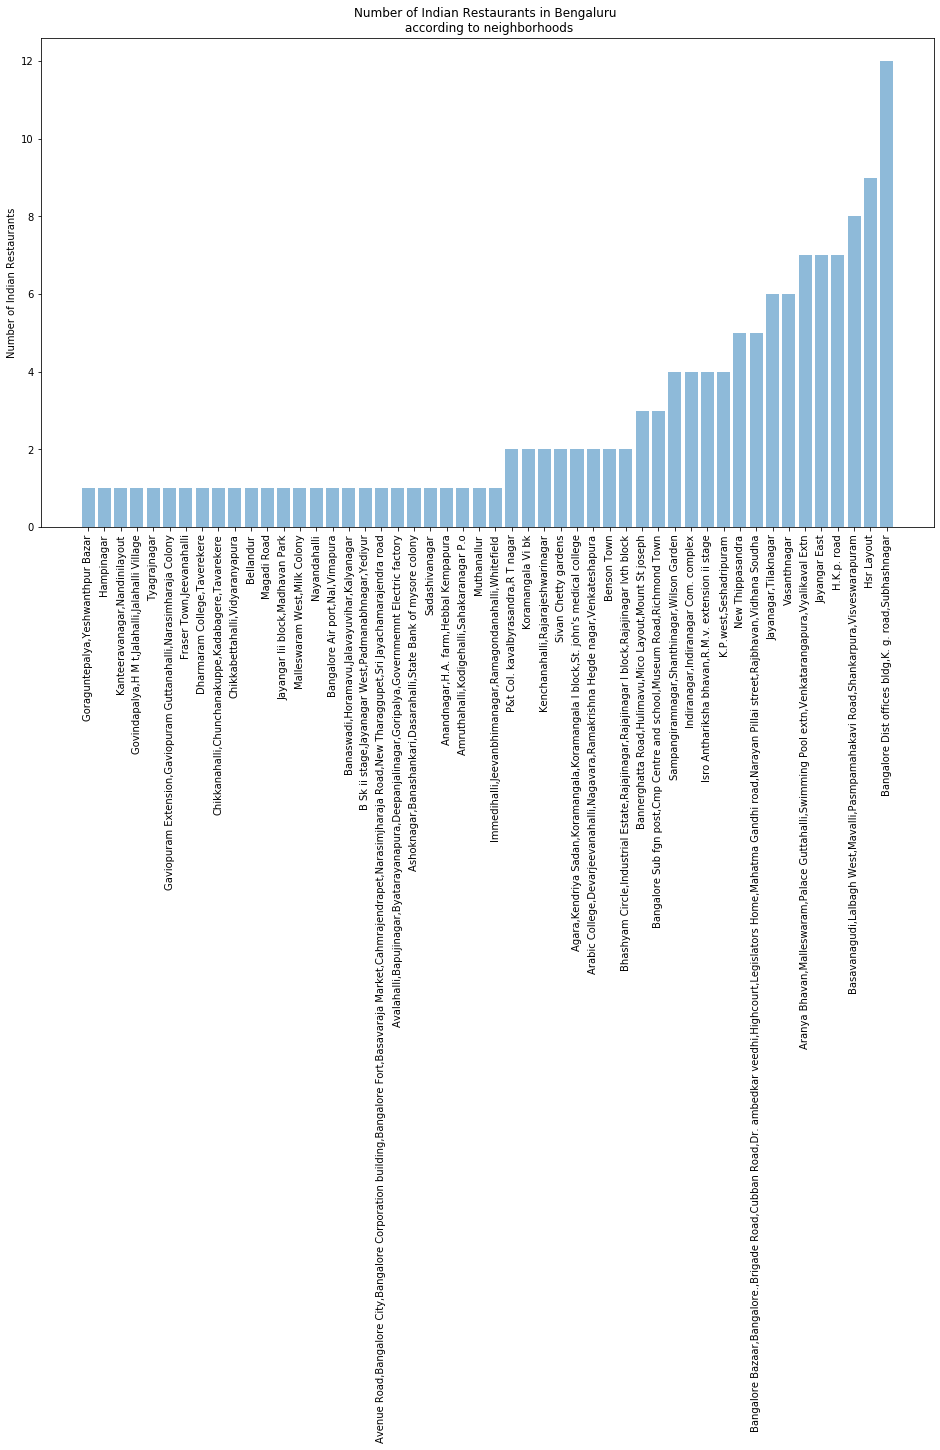

In [41]:
import matplotlib.pyplot as plt
import numpy as np
objects=tmp_data.index
y_pos=np.arange(len(objects))
freq=tmp_data['Venue Category']

plt.figure(figsize=[16,9])
plt.bar(y_pos,freq,align='center',alpha=0.5)
plt.xticks(y_pos,objects,rotation=90)
plt.ylabel('Number of Indian Restaurants')
plt.title('Number of Indian Restaurants in Bengaluru \n according to neighborhoods')
plt.show()

Now we will Analyze Each Neighborhood

In [42]:
# one hot encoding
blore_onehot = pd.get_dummies(blore_venues[['Venue Category']], prefix="", prefix_sep="")

In [43]:
# add neighborhood column back to dataframe
blore_onehot['Neighborhood'] =blore_venues['Neighborhood'] 
blore_onehot.head()

,ATM,Afghan Restaurant,Airport Service,American Restaurant,Arcade,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Badminton Court,Bakery,Bar,Baseball Stadium,Basketball Court,Bed & Breakfast,Beer Garden,Bike Shop,Bistro,Boarding House,Boat or Ferry,Bookstore,Breakfast Spot,Brewery,Burger Joint,Bus Station,Cafeteria,Café,Candy Store,Chettinad Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cricket Ground,Cupcake Shop,Department Store,Dessert Shop,Dhaba,Diner,Donut Shop,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Flea Market,Food Court,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Grocery Store,Gym,Gym / Fitness Center,Health Food Store,Hockey Arena,Home Service,Hookah Bar,Hotel,Hyderabadi Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karnataka Restaurant,Kerala Restaurant,Lake,Light Rail Station,Liquor Store,Lounge,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Music Venue,Nightclub,Noodle House,North Indian Restaurant,Optical Shop,Outdoors & Recreation,Park,Performing Arts Venue,Photography Studio,Pizza Place,Planetarium,Playground,Plaza,Pool,Pool Hall,Pub,Punjabi Restaurant,Rajasthani Restaurant,Restaurant,Salad Place,Sandwich Place,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Snack Place,Social Club,South Indian Restaurant,Spa,Stadium,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Tea Room,Tennis Court,Theater,Toll Plaza,Toy / Game Store,Trail,Train Station,Travel & Transport,Turkish Restaurant,Vegetarian / Vegan Restaurant,Watch Shop,Wine Bar,Wine Shop,Women's Store,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Bangalore Bazaar,Bangalore.,Brigade Road,Cubba..."
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Bangalore Bazaar,Bangalore.,Brigade Road,Cubba..."
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Bangalore Bazaar,Bangalore.,Brigade Road,Cubba..."
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Bangalore Bazaar,Bangalore.,Brigade Road,Cubba..."
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Bangalore Bazaar,Bangalore.,Brigade Road,Cubba..."


In [44]:
# move neighborhood column to the first column
fixed_columns = [blore_onehot.columns[-1]] + list(blore_onehot.columns[:-1])
blore_onehot = blore_onehot[fixed_columns]

blore_onehot.head(10)

,Neighborhood,ATM,Afghan Restaurant,Airport Service,American Restaurant,Arcade,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Badminton Court,Bakery,Bar,Baseball Stadium,Basketball Court,Bed & Breakfast,Beer Garden,Bike Shop,Bistro,Boarding House,Boat or Ferry,Bookstore,Breakfast Spot,Brewery,Burger Joint,Bus Station,Cafeteria,Café,Candy Store,Chettinad Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cricket Ground,Cupcake Shop,Department Store,Dessert Shop,Dhaba,Diner,Donut Shop,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Flea Market,Food Court,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Grocery Store,Gym,Gym / Fitness Center,Health Food Store,Hockey Arena,Home Service,Hookah Bar,Hotel,Hyderabadi Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karnataka Restaurant,Kerala Restaurant,Lake,Light Rail Station,Liquor Store,Lounge,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Music Venue,Nightclub,Noodle House,North Indian Restaurant,Optical Shop,Outdoors & Recreation,Park,Performing Arts Venue,Photography Studio,Pizza Place,Planetarium,Playground,Plaza,Pool,Pool Hall,Pub,Punjabi Restaurant,Rajasthani Restaurant,Restaurant,Salad Place,Sandwich Place,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Snack Place,Social Club,South Indian Restaurant,Spa,Stadium,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Tea Room,Tennis Court,Theater,Toll Plaza,Toy / Game Store,Trail,Train Station,Travel & Transport,Turkish Restaurant,Vegetarian / Vegan Restaurant,Watch Shop,Wine Bar,Wine Shop,Women's Store
0,"Bangalore Bazaar,Bangalore.,Brigade Road,Cubba...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Bangalore Bazaar,Bangalore.,Brigade Road,Cubba...",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Bangalore Bazaar,Bangalore.,Brigade Road,Cubba...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Bangalore Bazaar,Bangalore.,Brigade Road,Cubba...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Bangalore Bazaar,Bangalore.,Brigade Road,Cubba...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,"Bangalore Bazaar,Bangalore.,Brigade Road,Cubba...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

And let's examine the new dataframe size.

In [45]:
blore_onehot.shape

(747, 148)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [46]:
blore_grouped = blore_onehot.groupby('Neighborhood').mean().reset_index()
#blore_grouped=blore_grouped.drop(['Unnamed: 0'], axis=1)
blore_grouped.head()

,Neighborhood,ATM,Afghan Restaurant,Airport Service,American Restaurant,Arcade,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Badminton Court,Bakery,Bar,Baseball Stadium,Basketball Court,Bed & Breakfast,Beer Garden,Bike Shop,Bistro,Boarding House,Boat or Ferry,Bookstore,Breakfast Spot,Brewery,Burger Joint,Bus Station,Cafeteria,Café,Candy Store,Chettinad Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cricket Ground,Cupcake Shop,Department Store,Dessert Shop,Dhaba,Diner,Donut Shop,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Flea Market,Food Court,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Grocery Store,Gym,Gym / Fitness Center,Health Food Store,Hockey Arena,Home Service,Hookah Bar,Hotel,Hyderabadi Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karnataka Restaurant,Kerala Restaurant,Lake,Light Rail Station,Liquor Store,Lounge,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Music Venue,Nightclub,Noodle House,North Indian Restaurant,Optical Shop,Outdoors & Recreation,Park,Performing Arts Venue,Photography Studio,Pizza Place,Planetarium,Playground,Plaza,Pool,Pool Hall,Pub,Punjabi Restaurant,Rajasthani Restaurant,Restaurant,Salad Place,Sandwich Place,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Snack Place,Social Club,South Indian Restaurant,Spa,Stadium,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Tea Room,Tennis Court,Theater,Toll Plaza,Toy / Game Store,Trail,Train Station,Travel & Transport,Turkish Restaurant,Vegetarian / Vegan Restaurant,Watch Shop,Wine Bar,Wine Shop,Women's Store
0,A F station yelahanka,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Adugodi,Hosur Road",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Agara,Kendriya Sadan,Koramangala,Koramangala I...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

Let's confirm the new size

In [47]:
blore_grouped.shape

(84, 148)

Let's print each neighborhood along with the top 5 most common venues

In [48]:
num_top_venues = 5

for hood in blore_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = blore_grouped[blore_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----A F station yelahanka----
                     venue  freq
0          Airport Service   1.0
1                      ATM   0.0
2  North Indian Restaurant   0.0
3          Motorcycle Shop   0.0
4            Movie Theater   0.0


----Adugodi,Hosur Road----
                            venue  freq
0                     Bus Station  0.50
1                            Café  0.25
2            Fast Food Restaurant  0.25
3                             ATM  0.00
4  Multicuisine Indian Restaurant  0.00


----Agara,Kendriya Sadan,Koramangala,Koramangala I block,St. john's medical college----
                    venue  freq
0       Indian Restaurant   0.4
1  Furniture / Home Store   0.2
2                    Café   0.2
3          Ice Cream Shop   0.2
4     Japanese Restaurant   0.0


----Agram,Air Force hospital----
                            venue  freq
0                             ATM   1.0
1                           Plaza   0.0
2                 Motorcycle Shop   0.0
3                   Movie 

4            Stadium   0.2


----K.P.west,Seshadripuram----
                  venue  freq
0        Clothing Store  0.12
1     Indian Restaurant  0.10
2  Fast Food Restaurant  0.07
3     Electronics Store  0.05
4            Donut Shop  0.05


----Kacharakanahalli,Lingarajapuram,St. thomas town----
             venue  freq
0              ATM  0.67
1           Bakery  0.33
2     Noodle House  0.00
3  Motorcycle Shop  0.00
4    Movie Theater  0.00


----Kanteeravanagar,Nandinilayout----
                            venue  freq
0               Indian Restaurant   1.0
1                           Plaza   0.0
2                 Motorcycle Shop   0.0
3                   Movie Theater   0.0
4  Multicuisine Indian Restaurant   0.0


----Kenchanahalli,Rajarajeshwarinagar----
                            venue  freq
0               Indian Restaurant  0.67
1                      Restaurant  0.33
2         North Indian Restaurant  0.00
3                   Movie Theater  0.00
4  Multicuisine Indian Resta

Let's put that into a pandas dataframe

First, let's write a function to sort the venues in descending order.


In [49]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [50]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = blore_grouped['Neighborhood']

for ind in np.arange(blore_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(blore_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A F station yelahanka,Airport Service,Women's Store,Eastern European Restaurant,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store
1,"Adugodi,Hosur Road",Bus Station,Fast Food Restaurant,Café,Women's Store,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Eastern European Restaurant
2,"Agara,Kendriya Sadan,Koramangala,Koramangala I...",Indian Restaurant,Café,Ice Cream Shop,Furniture / Home Store,Eastern European Restaurant,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space
3,"Agram,Air Force hospital",ATM,Convenience Store,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Eastern European Restaurant
4,"Amruthahalli,Kodigehalli,Sahakaranagar P.o",Café,Bakery,Ice Cream Shop,Indian Restaurant,Sandwich Place,Light Rail Station,Snack Place,Fast Food Restaurant,Farmers Market,Farm


__________________

## Part 3

Run k-means to cluster the neighborhood into n clusters whose value will be determined by elbow method.

In [51]:
blore_grouped_clustering = blore_grouped.drop('Neighborhood', 1)

In [52]:
#Building the clustering model and calculating the values of the Distortion and Inertia
import scipy.spatial.distance
# run k-means clustering
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 

for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(blore_grouped_clustering) 
    kmeanModel.fit(blore_grouped_clustering)     
      
    distortions.append(sum(np.min(scipy.spatial.distance.cdist(blore_grouped_clustering, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / blore_grouped_clustering.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(scipy.spatial.distance.cdist(blore_grouped_clustering, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / blore_grouped_clustering.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

Tabulating and Visualizing the results

a) Using the different values of Distortion

In [53]:
for key,val in mapping1.items(): 
	print(str(key)+' : '+str(val)) 


1 : 0.4806488005732627
2 : 0.44458209027305856
3 : 0.42529744814477716
4 : 0.4132435283128884
5 : 0.40144126456551765
6 : 0.395046958022094
7 : 0.3827217557517267
8 : 0.3717188336687145
9 : 0.357516404918188


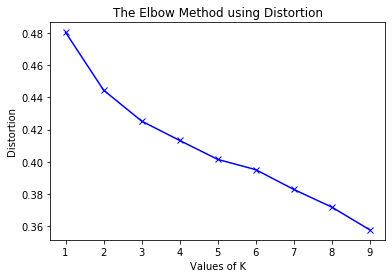

In [54]:
import matplotlib.pyplot as plt
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 


b) Using the different values of Inertia

In [55]:
for key,val in mapping2.items(): 
	print(str(key)+' : '+str(val)) 


1 : 23.751596484131277
2 : 20.53558478914212
3 : 18.905843721205642
4 : 17.908198402536463
5 : 16.932387603868946
6 : 16.428838004929624
7 : 15.498581215325027
8 : 14.495602760776588
9 : 13.566460633788179


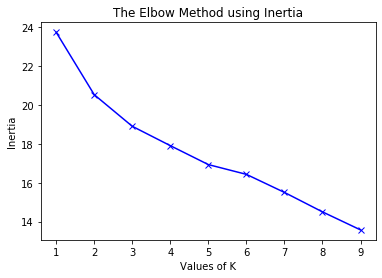

In [56]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 


<b>We find the Elbow:the point after which the distortion/inertia start decreasing in a linear fashion to be 6.<b>

Run k-means to cluster the neighborhood into 6 clusters.


In [57]:
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(blore_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([5, 0, 4, 1, 0, 4, 4, 4, 5, 5])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [58]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

neighborhoods_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,5,A F station yelahanka,Airport Service,Women's Store,Eastern European Restaurant,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store
1,0,"Adugodi,Hosur Road",Bus Station,Fast Food Restaurant,Café,Women's Store,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Eastern European Restaurant
2,4,"Agara,Kendriya Sadan,Koramangala,Koramangala I...",Indian Restaurant,Café,Ice Cream Shop,Furniture / Home Store,Eastern European Restaurant,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space
3,1,"Agram,Air Force hospital",ATM,Convenience Store,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Eastern European Restaurant
4,0,"Amruthahalli,Kodigehalli,Sahakaranagar P.o",Café,Bakery,Ice Cream Shop,Indian Restaurant,Sandwich Place,Light Rail Station,Snack Place,Fast Food Restaurant,Farmers Market,Farm


In [59]:
blore_merged = nhood_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
blore_merged = blore_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

blore_merged # check the last columns!

,Pin_Code,Neighborhood,Latitude,Longitude,Pin_Code.1,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,560001,"Bangalore Bazaar,Bangalore.,Brigade Road,Cubba...",12.977776,77.599500,560001,5.0,Indian Restaurant,Lounge,Café,Chinese Restaurant,Fast Food Restaurant,Metro Station,Science Museum,Bookstore,Cricket Ground,Bistro
1,560002,"Avenue Road,Bangalore City,Bangalore Corporati...",12.963811,77.582112,560002,5.0,Theater,South Indian Restaurant,Indian Restaurant,Market,Electronics Store,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
2,560003,"Aranya Bhavan,Malleswaram,Palace Guttahalli,Sw...",13.002018,77.571651,560003,4.0,Indian Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,Pizza Place,Ice Cream Shop,Social Club,Café,Snack Place,South Indian Restaurant,Flea Market
3,560004,"Basavanagudi,Lalbagh West,Mavalli,Pasmpamahaka...",12.943886,77.573945,560004,4.0,Indian Restaurant,Restaurant,Fast Food Restaurant,Convenience Store,Athletics & Sports,Hookah Bar,Dessert Shop,Farmers Market,Metro Station,Mediterranean Restaurant
4,560005,"Fraser Town,Jeevanahalli",12.998097,77.622781,560005,5.0,Coffee Shop,Indian Restaurant,Shopping Mall,Chinese Restaurant,Café,Vegetarian / Vegan Restaurant,Dessert Shop,Department Store,Dhaba,Diner
5,560006,"J.C.nagar,Training Command iaf",13.014232,77.587921,560006,5.0,Field,Farmers Market,Vegetarian / Vegan Restaurant,Event Space,Bus Station,Eastern European Restaurant,Fast Food Restaurant,Farm,Falafel Restaurant,Electronics Store
6,560007,"Agram,Air Force hospital",12.958346,77.630860,560007,1.0,ATM,Convenience Store,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Eastern European Restaurant
7,560008,"H.A.l ii stage,Hulsur Bazaar,Someswarapura",12.982968,77.626101,560008,0.0,Pool,Bakery,Burger Joint,Women's Store,Electronics Store,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space
8,560009,"Bangalore Dist offices bldg,K. g. road,Subhash...",12.977271,77.577296,560009,4.0,Indian Restaurant,Hotel,Bed & Breakfast,Bus Station,Dessert Shop,Diner,Restaurant,Seafood Restaurant,Bookstore,Shopping Mall
9,560010,"Bhashyam Circle,Industrial Estate,Rajajinagar,...",12.985411,77.553435,560010,0.0,Bakery,Indian Restaurant,Café,Breakfast Spot,Snack Place,Dessert Shop,Dhaba,Diner,Donut Shop,Eastern European Restaurant


In [60]:
blore_merged.dropna(subset=["Cluster Labels"],inplace=True)

In [61]:
blore_merged["Cluster Labels"]=blore_merged["Cluster Labels"].astype(int)

Finally, let's visualize the resulting clusters


In [62]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(blore_merged['Latitude'], blore_merged['Longitude'], blore_merged['Neighborhood'], blore_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now we will Examine Clusters to see what distinguises them.

Cluster 1

In [63]:
blore_merged.loc[blore_merged['Cluster Labels'] == 0, blore_merged.columns[[1] + list(range(5, blore_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,"H.A.l ii stage,Hulsur Bazaar,Someswarapura",0,Pool,Bakery,Burger Joint,Women's Store,Electronics Store,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space
9,"Bhashyam Circle,Industrial Estate,Rajajinagar,...",0,Bakery,Indian Restaurant,Café,Breakfast Spot,Snack Place,Dessert Shop,Dhaba,Diner,Donut Shop,Eastern European Restaurant
20,"Gayathrinagar,Okalipuram,Ramachandrapuram,Srir...",0,Café,Fast Food Restaurant,Park,Bakery,Eastern European Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store
29,"Adugodi,Hosur Road",0,Bus Station,Fast Food Restaurant,Café,Women's Store,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Eastern European Restaurant
50,"M S r road,Mathikere,Msrit",0,Music Venue,Park,Indie Movie Theater,Bakery,Women's Store,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space
54,Rv Niketan,0,Vegetarian / Vegan Restaurant,Bakery,Women's Store,Electronics Store,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space
62,"Bommanahalli,Hongasandra,Madivala",0,Department Store,Bakery,Women's Store,Electronics Store,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space
66,Nagarbhavi,0,Sandwich Place,Breakfast Spot,Café,Women's Store,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store
71,Kothanur,0,Photography Studio,Asian Restaurant,Kerala Restaurant,Café,Middle Eastern Restaurant,Dessert Shop,Dhaba,Diner,Donut Shop,Department Store
74,Sadashivanagar,0,Playground,Dessert Shop,Fast Food Restaurant,Bakery,Café,Boat or Ferry,Indian Restaurant,Ice Cream Shop,Performing Arts Venue,Department Store


Cluster 2

In [64]:
blore_merged.loc[blore_merged['Cluster Labels'] == 1, blore_merged.columns[[1] + list(range(5, blore_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,"Agram,Air Force hospital",1,ATM,Convenience Store,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Eastern European Restaurant
53,"Peenya I stage,Peenya Ii stage,Peenya Small in...",1,ATM,Convenience Store,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Eastern European Restaurant
65,Domlur,1,ATM,Bakery,Electronics Store,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Eastern European Restaurant
73,"Basaveshwaranagar,K H b colony,Kamakshipalya",1,ATM,Home Service,Eastern European Restaurant,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop
76,"Kacharakanahalli,Lingarajapuram,St. thomas town",1,ATM,Bakery,Electronics Store,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Eastern European Restaurant
78,"Avani Sringeri mutt,Basaveswaranagar Ii stage,...",1,ATM,Bakery,Department Store,Pizza Place,Hockey Arena,Field,Cricket Ground,Cupcake Shop,Hookah Bar,Dessert Shop


Cluster 3

In [65]:
blore_merged.loc[blore_merged['Cluster Labels'] == 2, blore_merged.columns[[1] + list(range(5, blore_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
61,"Devanagundi,Kadugodi,Kalkunte,Kannamangala,Med...",2,Furniture / Home Store,Women's Store,Flea Market,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Eastern European Restaurant


In [ ]:
Cluster 4

In [66]:
blore_merged.loc[blore_merged['Cluster Labels'] == 3, blore_merged.columns[[1] + list(range(5, blore_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
98,"Bettahalsur,Chikkajala,Doddajala,Hunasamaranah...",3,Dhaba,Women's Store,Electronics Store,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Eastern European Restaurant


In [ ]:
Cluster 5

In [67]:
blore_merged.loc[blore_merged['Cluster Labels'] == 4, blore_merged.columns[[1] + list(range(5, blore_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Aranya Bhavan,Malleswaram,Palace Guttahalli,Sw...",4,Indian Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,Pizza Place,Ice Cream Shop,Social Club,Café,Snack Place,South Indian Restaurant,Flea Market
3,"Basavanagudi,Lalbagh West,Mavalli,Pasmpamahaka...",4,Indian Restaurant,Restaurant,Fast Food Restaurant,Convenience Store,Athletics & Sports,Hookah Bar,Dessert Shop,Farmers Market,Metro Station,Mediterranean Restaurant
8,"Bangalore Dist offices bldg,K. g. road,Subhash...",4,Indian Restaurant,Hotel,Bed & Breakfast,Bus Station,Dessert Shop,Diner,Restaurant,Seafood Restaurant,Bookstore,Shopping Mall
12,"Govindapalya,H M t,Jalahalli,Jalahalli Village",4,Fast Food Restaurant,Plaza,Indian Restaurant,Shopping Mall,Eastern European Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store
16,"Bangalore Air port,Nal,Vimapura",4,Food Truck,Indian Restaurant,Garden,Café,Department Store,Dessert Shop,Dhaba,Diner,Donut Shop,Flea Market
18,"Gaviopuram Extension,Gaviopuram Guttanahalli,N...",4,Fast Food Restaurant,Indian Restaurant,Breakfast Spot,South Indian Restaurant,Women's Store,Electronics Store,Farmers Market,Farm,Falafel Restaurant,Event Space
23,"Anandnagar,H.A. farm,Hebbal Kempapura",4,Indian Restaurant,Train Station,Bakery,Lake,Women's Store,Event Space,Field,Fast Food Restaurant,Farmers Market,Farm
25,"Avalahalli,Bapujinagar,Byatarayanapura,Deepanj...",4,Metro Station,Indian Restaurant,Travel & Transport,Café,Department Store,Dessert Shop,Cupcake Shop,Dhaba,Diner,Donut Shop
26,"Sampangiramnagar,Shanthinagar,Wilson Garden",4,Indian Restaurant,Convenience Store,Movie Theater,Multiplex,Café,Japanese Restaurant,Middle Eastern Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,Department Store
30,"P&t Col. kavalbyrasandra,R T nagar",4,Indian Restaurant,Snack Place,Vegetarian / Vegan Restaurant,Motorcycle Shop,Chinese Restaurant,Fast Food Restaurant,Eastern European Restaurant,Farmers Market,Farm,Falafel Restaurant


Cluster 6

In [68]:
blore_merged.loc[blore_merged['Cluster Labels'] == 5, blore_merged.columns[[1] + list(range(5, blore_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Bangalore Bazaar,Bangalore.,Brigade Road,Cubba...",5,Indian Restaurant,Lounge,Café,Chinese Restaurant,Fast Food Restaurant,Metro Station,Science Museum,Bookstore,Cricket Ground,Bistro
1,"Avenue Road,Bangalore City,Bangalore Corporati...",5,Theater,South Indian Restaurant,Indian Restaurant,Market,Electronics Store,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
4,"Fraser Town,Jeevanahalli",5,Coffee Shop,Indian Restaurant,Shopping Mall,Chinese Restaurant,Café,Vegetarian / Vegan Restaurant,Dessert Shop,Department Store,Dhaba,Diner
5,"J.C.nagar,Training Command iaf",5,Field,Farmers Market,Vegetarian / Vegan Restaurant,Event Space,Bus Station,Eastern European Restaurant,Fast Food Restaurant,Farm,Falafel Restaurant,Electronics Store
10,"Jayangar Iii block,Madhavan Park",5,Stadium,Indian Restaurant,Clothing Store,Jewelry Store,Lounge,Women's Store,Electronics Store,Fast Food Restaurant,Farmers Market,Farm
11,Science Institute,5,Bookstore,Women's Store,Flea Market,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Eastern European Restaurant
14,"Jalahalli West,Kamagondanahalli",5,Gym,Women's Store,Eastern European Restaurant,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop
15,"Doorvaninagar,Krishnarajapuram R s,Ramamurthy ...",5,IT Services,Supermarket,Optical Shop,ATM,Vegetarian / Vegan Restaurant,Donut Shop,Farmers Market,Farm,Falafel Restaurant,Event Space
17,"Chamrajpet,Chamrajpet Bazar,Vittalnagar",5,Juice Bar,Vegetarian / Vegan Restaurant,Movie Theater,Eastern European Restaurant,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store
19,"K.P.west,Seshadripuram",5,Clothing Store,Indian Restaurant,Fast Food Restaurant,Coffee Shop,Donut Shop,Electronics Store,Bakery,Ice Cream Shop,Café,Sandwich Place


We find that the Cluster 5 has Indian Restaurant as it's most common venue and hence in our final list we will ignore Cluster 5.

In [ ]:
# Rough work for part 4

In [81]:
cl5_list=(blore_merged.loc[blore_merged['Cluster Labels'] == 4, blore_merged.columns[[1] + list(range(5, blore_merged.shape[1]))]].index)

In [82]:
cl5_list

Int64Index([ 2,  3,  8, 12, 16, 18, 23, 25, 26, 30, 32, 35, 41, 63, 69, 70, 83,
            85, 86, 87, 90, 92],
           dtype='int64')

In [83]:
final_data=blore_merged.drop([2,  3,  8, 12, 16, 18, 23, 25, 26, 30, 32, 35, 41, 63, 69, 70, 83,85, 86, 87, 90, 92],axis=0)

In [84]:
# we will remove those Neighborhoods that still have indian restaurants as their top venue.
First=final_data['1st Most Common Venue']=="Indian Restaurant"

final_data=final_data[~First]


In [85]:
final_data

,Pin_Code,Neighborhood,Latitude,Longitude,Pin_Code.1,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,560002,"Avenue Road,Bangalore City,Bangalore Corporati...",12.963811,77.582112,560002,5,Theater,South Indian Restaurant,Indian Restaurant,Market,Electronics Store,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
4,560005,"Fraser Town,Jeevanahalli",12.998097,77.622781,560005,5,Coffee Shop,Indian Restaurant,Shopping Mall,Chinese Restaurant,Café,Vegetarian / Vegan Restaurant,Dessert Shop,Department Store,Dhaba,Diner
5,560006,"J.C.nagar,Training Command iaf",13.014232,77.587921,560006,5,Field,Farmers Market,Vegetarian / Vegan Restaurant,Event Space,Bus Station,Eastern European Restaurant,Fast Food Restaurant,Farm,Falafel Restaurant,Electronics Store
6,560007,"Agram,Air Force hospital",12.958346,77.630860,560007,1,ATM,Convenience Store,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Eastern European Restaurant
7,560008,"H.A.l ii stage,Hulsur Bazaar,Someswarapura",12.982968,77.626101,560008,0,Pool,Bakery,Burger Joint,Women's Store,Electronics Store,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space
9,560010,"Bhashyam Circle,Industrial Estate,Rajajinagar,...",12.985411,77.553435,560010,0,Bakery,Indian Restaurant,Café,Breakfast Spot,Snack Place,Dessert Shop,Dhaba,Diner,Donut Shop,Eastern European Restaurant
10,560011,"Jayangar Iii block,Madhavan Park",12.933897,77.590048,560011,5,Stadium,Indian Restaurant,Clothing Store,Jewelry Store,Lounge,Women's Store,Electronics Store,Fast Food Restaurant,Farmers Market,Farm
11,560012,Science Institute,13.014274,77.565752,560012,5,Bookstore,Women's Store,Flea Market,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Eastern European Restaurant
14,560015,"Jalahalli West,Kamagondanahalli",13.062747,77.528513,560015,5,Gym,Women's Store,Eastern European Restaurant,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop
15,560016,"Doorvaninagar,Krishnarajapuram R s,Ramamurthy ...",13.017800,77.680541,560016,5,IT Services,Supermarket,Optical Shop,ATM,Vegetarian / Vegan Restaurant,Donut Shop,Farmers Market,Farm,Falafel Restaurant,Event Space


________________

## Part 4

### Discussions

From the classification excercise it is established that the neighborhoods in Bengaluru city can be effectively clustered into 6 clusters based on the information obtained from Foursquare API about the top 10 venues in that neighborhood.

Our business problem wanted is to select prospective neighborhoods for out restaurant chain. We wanted those neighborhoods which don't have many restaurants.

From the clustering data it is evident that the cluster 5 has been clustered based on availability of restaurants and eateries.

Hence we will suggest our client to look at the neighborhoods that fall outside Cluster 5.Also the occourances of Indian restaurants as the 1st most common venue have been deleted and the final list of neighborhoods are:

In [86]:
final_data

,Pin_Code,Neighborhood,Latitude,Longitude,Pin_Code.1,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,560002,"Avenue Road,Bangalore City,Bangalore Corporati...",12.963811,77.582112,560002,5,Theater,South Indian Restaurant,Indian Restaurant,Market,Electronics Store,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
4,560005,"Fraser Town,Jeevanahalli",12.998097,77.622781,560005,5,Coffee Shop,Indian Restaurant,Shopping Mall,Chinese Restaurant,Café,Vegetarian / Vegan Restaurant,Dessert Shop,Department Store,Dhaba,Diner
5,560006,"J.C.nagar,Training Command iaf",13.014232,77.587921,560006,5,Field,Farmers Market,Vegetarian / Vegan Restaurant,Event Space,Bus Station,Eastern European Restaurant,Fast Food Restaurant,Farm,Falafel Restaurant,Electronics Store
6,560007,"Agram,Air Force hospital",12.958346,77.630860,560007,1,ATM,Convenience Store,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Eastern European Restaurant
7,560008,"H.A.l ii stage,Hulsur Bazaar,Someswarapura",12.982968,77.626101,560008,0,Pool,Bakery,Burger Joint,Women's Store,Electronics Store,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space
9,560010,"Bhashyam Circle,Industrial Estate,Rajajinagar,...",12.985411,77.553435,560010,0,Bakery,Indian Restaurant,Café,Breakfast Spot,Snack Place,Dessert Shop,Dhaba,Diner,Donut Shop,Eastern European Restaurant
10,560011,"Jayangar Iii block,Madhavan Park",12.933897,77.590048,560011,5,Stadium,Indian Restaurant,Clothing Store,Jewelry Store,Lounge,Women's Store,Electronics Store,Fast Food Restaurant,Farmers Market,Farm
11,560012,Science Institute,13.014274,77.565752,560012,5,Bookstore,Women's Store,Flea Market,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Eastern European Restaurant
14,560015,"Jalahalli West,Kamagondanahalli",13.062747,77.528513,560015,5,Gym,Women's Store,Eastern European Restaurant,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Electronics Store,Donut Shop
15,560016,"Doorvaninagar,Krishnarajapuram R s,Ramamurthy ...",13.017800,77.680541,560016,5,IT Services,Supermarket,Optical Shop,ATM,Vegetarian / Vegan Restaurant,Donut Shop,Farmers Market,Farm,Falafel Restaurant,Event Space


In [87]:
print(final_data.shape)
print(nhood_data.shape)

(57, 16)
(99, 5)


Hence out of the 99 available neighbourhoods we have isolated 57 viable neighborhoods that do not have restaurants/eateries as their top common venue. 